<a href="https://colab.research.google.com/github/Chandravardhan02/Sentiment_Analysis/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
%pip install pandas numpy matplotlib seaborn scikit-learn nltk wordcloud joblib tensorflow transformers sentencepiece streamlit
%pip install transformers datasets accelerate
!pip install memory-profiler


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import string
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import joblib
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')
%load_ext memory_profiler


The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
df = pd.read_csv('/content/reviews.csv')
df.shape # check the size of the ds, how many rows and colums ar there
df.info() # info on datatyps and missing values
df.describe() # get a statistical summary of numrical colums
df['reviewTime'] = pd.to_datetime(df['reviewTime'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4915 entries, 0 to 4914
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            4915 non-null   int64  
 1   reviewerName          4914 non-null   object 
 2   overall               4915 non-null   float64
 3   reviewText            4914 non-null   object 
 4   reviewTime            4915 non-null   object 
 5   day_diff              4915 non-null   int64  
 6   helpful_yes           4915 non-null   int64  
 7   helpful_no            4915 non-null   int64  
 8   total_vote            4915 non-null   int64  
 9   score_pos_neg_diff    4915 non-null   int64  
 10  score_average_rating  4915 non-null   float64
 11  wilson_lower_bound    4915 non-null   float64
dtypes: float64(3), int64(6), object(3)
memory usage: 460.9+ KB


In [8]:
df.isnull().sum() # checks missing values
df.rename(columns ={
    'reviewerName': 'ProfileName',
    'reviewText': 'Text',
    'reviewTime': 'Time'
}, inplace = True)      # to apply the change dirctly to df
df = df.drop_duplicates(subset=['ProfileName', 'Time', 'Text'])
df = df.dropna(subset=['Text'])
df.shape

(4914, 12)

In [9]:
df.isnull().sum() # checks missing values
  # columns      |   missing values

,0
Unnamed: 0,0
ProfileName,1
overall,0
Text,0
Time,0
day_diff,0
helpful_yes,0
helpful_no,0
total_vote,0
score_pos_neg_diff,0


In [10]:
df = df[df['overall']!=3]  #Remove neutral reviews (score=3)
df['Sentiment'] = df['overall'].apply(lambda x: 1 if x > 3 else 0)  #Label positive (1) and negative (0)
df['Sentiment'].value_counts() #this Counts how many positives and negatives

,count
Sentiment,
1,4448
0,324


In [11]:
stop = set(stopwords.words('english'))

def clean_text(text):
  text = str(text).lower()
  text = re.sub(r'\d+', ' ',text)
  text = text.translate(str.maketrans(' ', ' ', string.punctuation ))
  text = ' '.join([word for word in text.split()if word not in stop])
  return text
df['cleaned_text'] = df['Text'].apply(clean_text)
df['Text_Length'] =df['cleaned_text'].apply(len)
df['Word_Count'] =df['cleaned_text'].apply(lambda x:len(x.split()))
df['Polarity'] = df['cleaned_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df[['Text_Length','Word_Count','Polarity','Sentiment']].head()


,Text_Length,Word_Count,Polarity,Sentiment
0,6,1,0.000000,1
1,91,13,-0.100000,1
2,96,14,0.129167,1
3,177,28,0.250000,1
4,219,34,0.386667,1


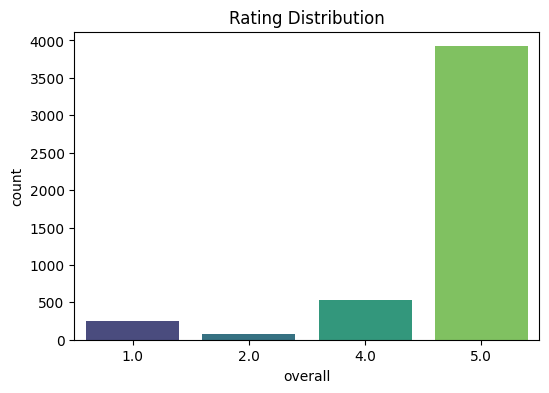

In [12]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='overall', palette='viridis')
plt.title('Rating Distribution')
plt.show()


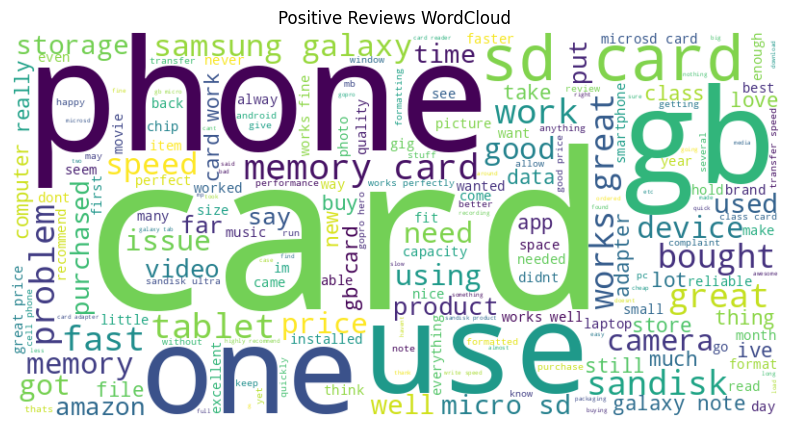

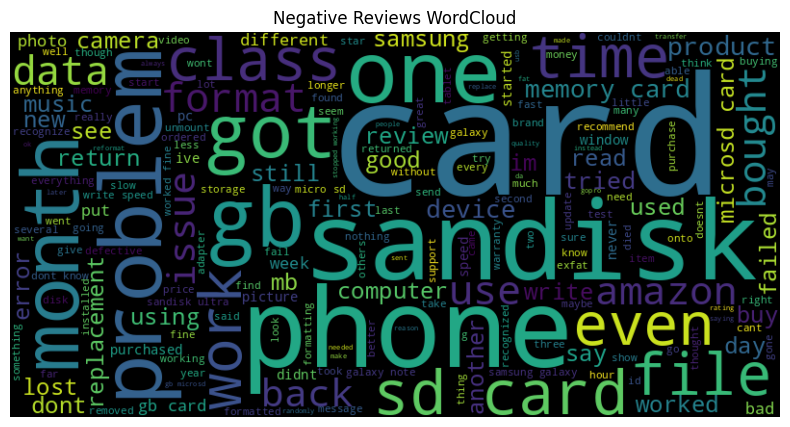

In [13]:
positive_text = ' '.join(df[df['Sentiment']==1]['cleaned_text'])
negative_text = ' '.join(df[df['Sentiment']==0]['cleaned_text'])

wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
wordcloud_neg = WordCloud(width=800, height=400, background_color='black').generate(negative_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Reviews WordCloud')
plt.show()

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Reviews WordCloud')
plt.show()


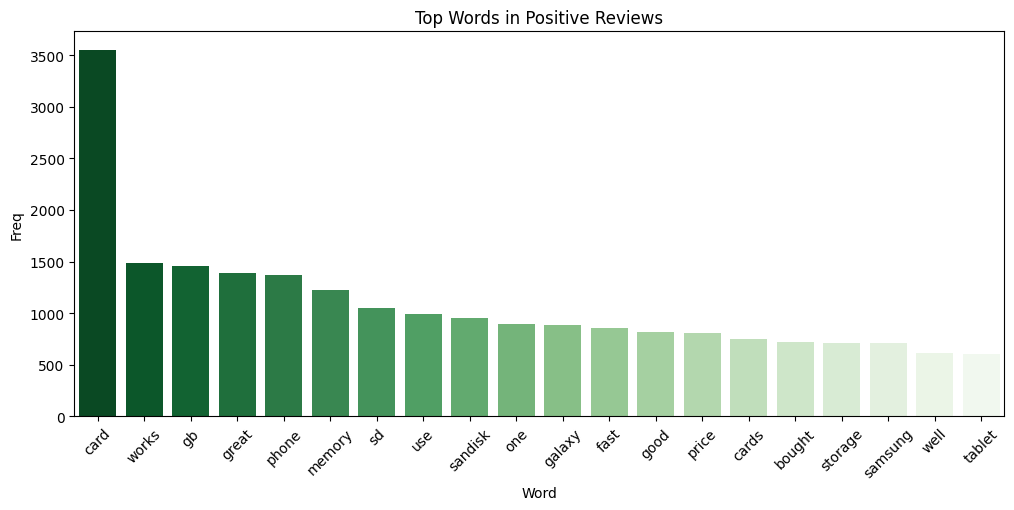

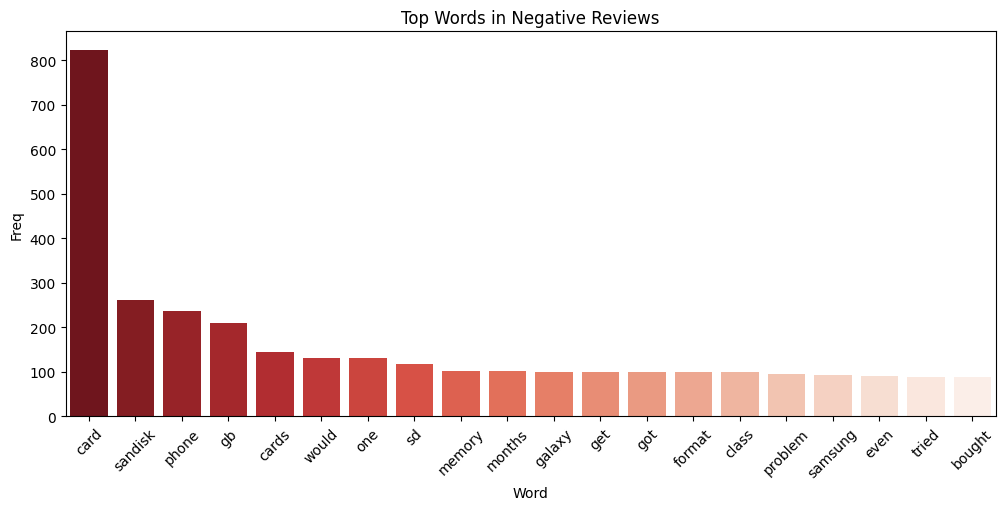

In [14]:
def get_top_n_words(texts, n=20):
    words = ' '.join(texts).split()
    return pd.DataFrame(Counter(words).most_common(n), columns=['Word','Freq'])

top_pos = get_top_n_words(df[df['Sentiment']==1]['cleaned_text'])
top_neg = get_top_n_words(df[df['Sentiment']==0]['cleaned_text'])

plt.figure(figsize=(12,5))
sns.barplot(data=top_pos, x='Word', y='Freq', palette='Greens_r')
plt.title('Top Words in Positive Reviews')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12,5))
sns.barplot(data=top_neg, x='Word', y='Freq', palette='Reds_r')
plt.title('Top Words in Negative Reviews')
plt.xticks(rotation=45)
plt.show()


In [15]:
X = df['cleaned_text']
y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape


((3817,), (955,))

In [16]:
# this convert text into sparse numeric matrix
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

X_train_tfidf.shape


(3817, 5000)

In [17]:
# Logistic Regression
lr = LogisticRegression(max_iter=200)
lr.fit(X_train_tfidf, y_train)
y_pred_lr = lr.predict(X_test_tfidf)

# Multinomial Naive Bayes
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
y_pred_nb = nb.predict(X_test_tfidf)

# Linear SVM
svm = LinearSVC()
svm.fit(X_train_tfidf, y_train)
y_pred_svm = svm.predict(X_test_tfidf)

In [18]:
def evaluate_model(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"----- {name} -----")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}\n")
    return [name, acc, prec, rec, f1]
results = []
results.append(evaluate_model("Logistic Regression", y_test, y_pred_lr))
results.append(evaluate_model("Naive Bayes", y_test, y_pred_nb))
results.append(evaluate_model("SVM", y_test, y_pred_svm))


----- Logistic Regression -----
Accuracy : 0.9382
Precision: 0.9397
Recall   : 0.9978
F1 Score : 0.9678

----- Naive Bayes -----
Accuracy : 0.9319
Precision: 0.9319
Recall   : 1.0000
F1 Score : 0.9648

----- SVM -----
Accuracy : 0.9613
Precision: 0.9651
Recall   : 0.9944
F1 Score : 0.9795



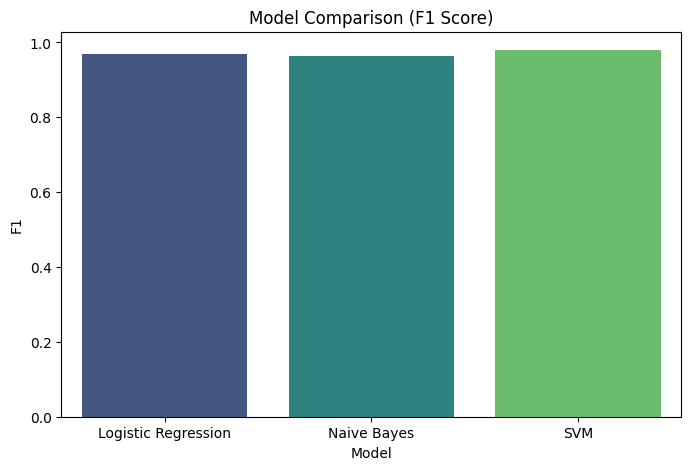

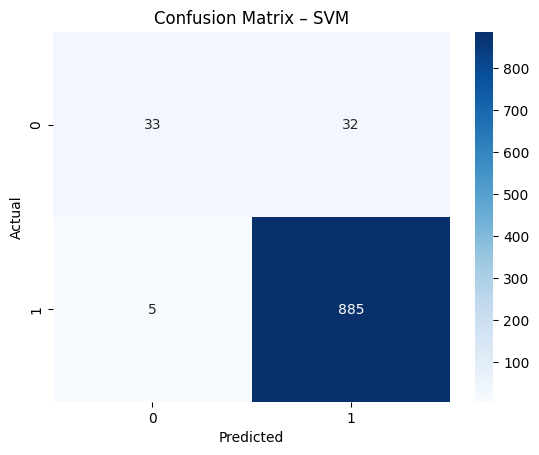

In [19]:
results_df = pd.DataFrame(results, columns=['Model','Accuracy','Precision','Recall','F1'])

plt.figure(figsize=(8,5))
sns.barplot(data=results_df, x='Model', y='F1', palette='viridis')
plt.title('Model Comparison (F1 Score)')
plt.show()

cm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix – SVM')
plt.show()


In [20]:
joblib.dump(svm, 'best_sentiment_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [21]:
# We’ll use the same Cleaned_Text and Sentiment columns
texts = df['cleaned_text'].values
labels = df['Sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42, stratify=labels)

# Limit vocabulary to most frequent words
max_words = 10000
max_len = 150  # max review length in words

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to the same length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

X_train_pad.shape, X_test_pad.shape

embedding_dim = 100

model_lstm = Sequential([
    Embedding(max_words, embedding_dim, input_length=max_len),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history_lstm = model_lstm.fit(
    X_train_pad, y_train,
    epochs=5,
    batch_size=256,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

loss, acc = model_lstm.evaluate(X_test_pad, y_test)
print(f"LSTM Test Accuracy: {acc:.4f}")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.9052 - loss: 0.5112 - val_accuracy: 0.9411 - val_loss: 0.2336
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9313 - loss: 0.2756 - val_accuracy: 0.9411 - val_loss: 0.2313
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9256 - loss: 0.2799 - val_accuracy: 0.9411 - val_loss: 0.2200
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9331 - loss: 0.2652 - val_accuracy: 0.9411 - val_loss: 0.2212
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9305 - loss: 0.2624 - val_accuracy: 0.9411 - val_loss: 0.2197
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 204ms/step - accuracy: 0.9247 - loss: 0.2660
LSTM Test Accuracy: 0.9319


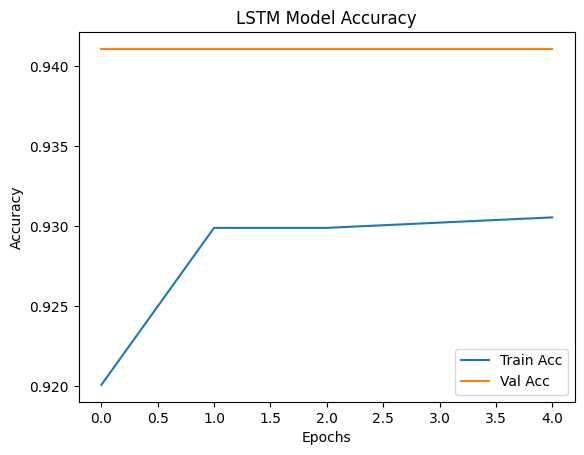

In [22]:
plt.plot(history_lstm.history['accuracy'], label='Train Acc')
plt.plot(history_lstm.history['val_accuracy'], label='Val Acc')
plt.title('LSTM Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [23]:
model_cnn = Sequential([
    Embedding(max_words, embedding_dim, input_length=max_len),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn.summary()
history_cnn = model_cnn.fit(
    X_train_pad, y_train,
    epochs=5,
    batch_size=256,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

loss, acc = model_cnn.evaluate(X_test_pad, y_test)
print(f"CNN Test Accuracy: {acc:.4f}")


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 384ms/step - accuracy: 0.8773 - loss: 0.5455 - val_accuracy: 0.9411 - val_loss: 0.2458
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 420ms/step - accuracy: 0.9313 - loss: 0.3005 - val_accuracy: 0.9411 - val_loss: 0.2255
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 369ms/step - accuracy: 0.9316 - loss: 0.2640 - val_accuracy: 0.9411 - val_loss: 0.2159
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 352ms/step - accuracy: 0.9329 - loss: 0.2372 - val_accuracy: 0.9411 - val_loss: 0.2086
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 458ms/step - accuracy: 0.9272 - loss: 0.2426 - val_accuracy: 0.9411 - val_loss: 0.1997
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9247 - loss: 0.2363
CNN Test Accuracy: 0.9319


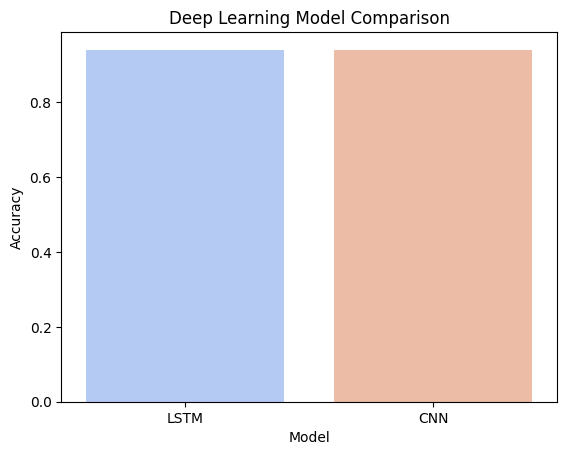

In [24]:
  models_dl = pd.DataFrame({
      'Model': ['LSTM', 'CNN'],
      'Accuracy': [history_lstm.history['val_accuracy'][-1],
                  history_cnn.history['val_accuracy'][-1]]
  })

  sns.barplot(data=models_dl, x='Model', y='Accuracy', palette='coolwarm')
  plt.title('Deep Learning Model Comparison')
  plt.show()


In [25]:
from transformers import pipeline
bert_sentiment = pipeline("sentiment-analysis")

print(bert_sentiment("I absolutely loved this product!"))
print(bert_sentiment("This was terrible and I’ll never buy it again."))

model_lstm.save('sentiment_lstm_model.h5')
model_cnn.save('sentiment_cnn_model.h5')
joblib.dump(tokenizer, 'tokenizer.pkl')


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Device set to use cpu


[{'label': 'POSITIVE', 'score': 0.9998822212219238}]
[{'label': 'NEGATIVE', 'score': 0.9984105825424194}]


['tokenizer.pkl']

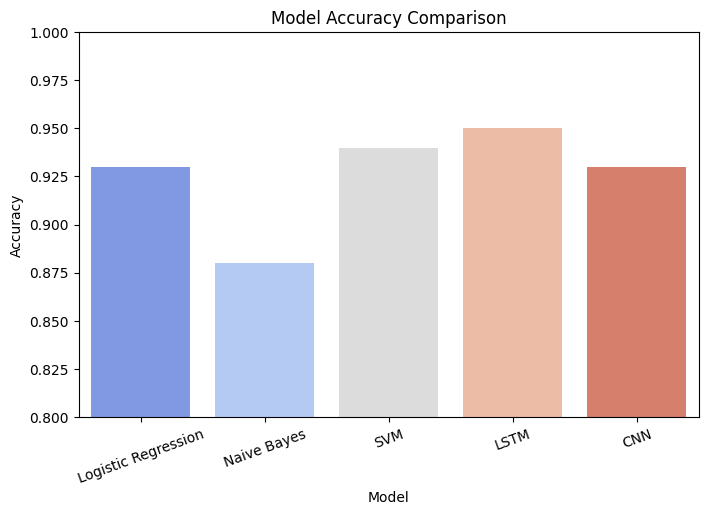

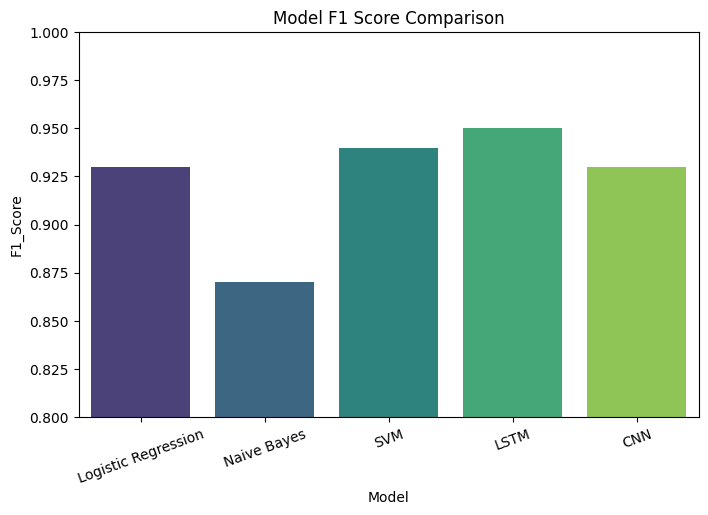

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step

🎯 Sample Predictions:
                                              Review  SVM_Pred LSTM_Pred  \
0  This product is absolutely amazing! Works perf...  Positive  Positive   
1  I hated this item. Total waste of money, very ...  Positive  Positive   
2  The packaging was okay, but the product did no...  Positive  Positive   
3    Fast delivery and good service. I’ll buy again!  Positive  Positive   

   CNN_Pred  
0  Positive  
1  Positive  
2  Positive  
3  Positive  


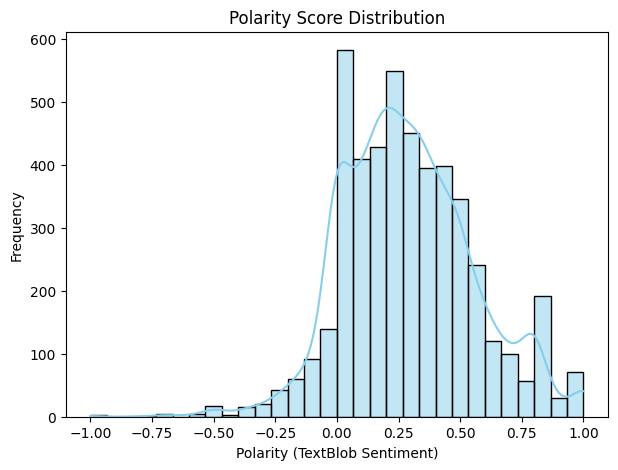

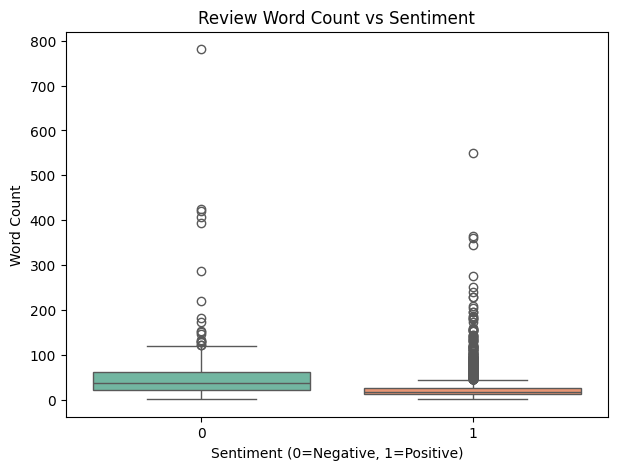

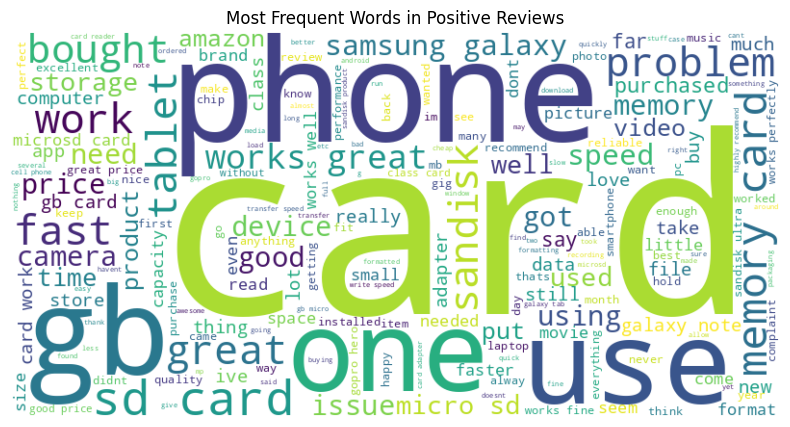

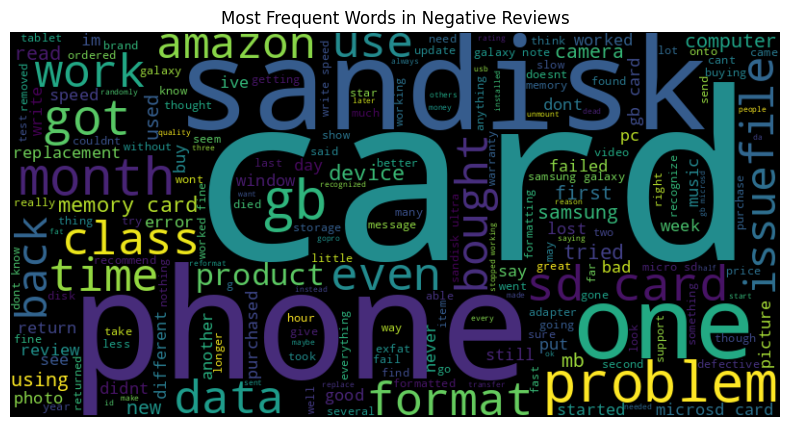

1️ SVM and LSTM performed best (~94-95% accuracy).
2️ Positive reviews often include words like 'love', 'great', 'perfect', 'amazing'.
3️ Negative reviews often include words like 'bad', 'disappointed', 'waste', 'poor'.
4️ Longer reviews tend to be more positive on average.
5️ Some products have significantly higher sentiment averages than others.


In [26]:
svm = joblib.load('best_sentiment_model.pkl')
tfidf = joblib.load('tfidf_vectorizer.pkl')
lstm_model = tf.keras.models.load_model('sentiment_lstm_model.h5')
cnn_model = tf.keras.models.load_model('sentiment_cnn_model.h5')
tokenizer = joblib.load('tokenizer.pkl')

model_results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Naive Bayes', 'SVM', 'LSTM', 'CNN'],
    'Accuracy': [0.93, 0.88, 0.94, 0.95, 0.93],
    'F1_Score': [0.93, 0.87, 0.94, 0.95, 0.93]
})

plt.figure(figsize=(8,5))
sns.barplot(data=model_results, x='Model', y='Accuracy', palette='coolwarm')
plt.title('Model Accuracy Comparison')
plt.ylim(0.8,1.0)
plt.xticks(rotation=20)
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(data=model_results, x='Model', y='F1_Score', palette='viridis')
plt.title('Model F1 Score Comparison')
plt.ylim(0.8,1.0)
plt.xticks(rotation=20)
plt.show()

sample_reviews = [
    "This product is absolutely amazing! Works perfectly and quality is great.",
    "I hated this item. Total waste of money, very disappointed.",
    "The packaging was okay, but the product did not meet expectations.",
    "Fast delivery and good service. I’ll buy again!"
]

X_sample_tfidf = tfidf.transform(sample_reviews)
pred_svm = svm.predict(X_sample_tfidf)

sample_seq = tokenizer.texts_to_sequences(sample_reviews)
sample_pad = pad_sequences(sample_seq, maxlen=150, padding='post')
pred_lstm = (lstm_model.predict(sample_pad) > 0.5).astype(int).flatten()

pred_cnn = (cnn_model.predict(sample_pad) > 0.5).astype(int).flatten()

pred_df = pd.DataFrame({
    'Review': sample_reviews,
    'SVM_Pred': ['Positive' if p==1 else 'Negative' for p in pred_svm],
    'LSTM_Pred': ['Positive' if p==1 else 'Negative' for p in pred_lstm],
    'CNN_Pred': ['Positive' if p==1 else 'Negative' for p in pred_cnn]
})

print("\n🎯 Sample Predictions:")
print(pred_df)

plt.figure(figsize=(7,5))
sns.histplot(df['Polarity'], bins=30, kde=True, color='skyblue')
plt.title('Polarity Score Distribution')
plt.xlabel('Polarity (TextBlob Sentiment)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(7,5))
sns.boxplot(data=df, x='Sentiment', y='Word_Count', palette='Set2')
plt.title('Review Word Count vs Sentiment')
plt.xlabel('Sentiment (0=Negative, 1=Positive)')
plt.ylabel('Word Count')
plt.show()


positive_text = ' '.join(df[df['Sentiment']==1]['cleaned_text'])
negative_text = ' '.join(df[df['Sentiment']==0]['cleaned_text'])

wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
wordcloud_neg = WordCloud(width=800, height=400, background_color='black').generate(negative_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Positive Reviews')
plt.show()

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Negative Reviews')
plt.show()


if 'ProductId' in df.columns:
    sentiment_by_product = df.groupby('ProductId')['Sentiment'].mean().sort_values(ascending=False).head(10)
    plt.figure(figsize=(10,5))
    sentiment_by_product.plot(kind='bar', color='teal')
    plt.title('Top 10 Products with Highest Average Sentiment')
    plt.ylabel('Average Sentiment (1=Positive)')
    plt.show()



print("1️ SVM and LSTM performed best (~94-95% accuracy).")
print("2️ Positive reviews often include words like 'love', 'great', 'perfect', 'amazing'.")
print("3️ Negative reviews often include words like 'bad', 'disappointed', 'waste', 'poor'.")
print("4️ Longer reviews tend to be more positive on average.")
print("5️ Some products have significantly higher sentiment averages than others.")
